In [34]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch, stft, butter, lfilter, sosfilt
from scipy.optimize import curve_fit

In [82]:
def get_filtered_signal(data, f_hp=10000, f_lp=100000):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0]))) # Sampling rate in Hz
    sos_hp = butter(8, f_hp, 'hp', fs=fs, output='sos')
    sos_lp = butter(8, f_lp, 'lp', fs=fs, output='sos')
    filtered = sosfilt(sos_hp, data[1])
    filtered_filtered = sosfilt(sos_lp, filtered)
    
    return filtered_filtered

def lowpass_filtered(tod, fs, f_lp=50000):
    sos_lp = butter(8, f_lp, 'lp', fs=fs, output='sos')
    filtered = sosfilt(sos_lp, tod)
    
    return filtered

def highpass_filtered(tod, fs, f_hp=50000):
    sos_hp = butter(8, f_hp, 'hp', fs=fs, output='sos')
    filtered = sosfilt(sos_hp, tod)
    
    return filtered

In [4]:
def plot_tod(data, title='', mv=False):
    fig, ax = plt.subplots(figsize = (20, 6))

    ax.plot(data[0], data[1], 'b', label="Z detection")
    if mv:
        ax.plot(data[0], data[2]/1000, 'r', label="Applied impulse signal")
    else:
        ax.plot(data[0], data[2], 'r', label="Applied impulse signal")
    try:
        ax.plot(data[0], data[4], label="Feedback signal")
    except:
        pass

    ax.legend(frameon=False, fontsize=18)
    ax.set_xlabel('Time (s)', fontsize=18)
    ax.set_ylabel('Signal (V)', fontsize=18)
    ax.set_title(title, fontsize=18)
    
    return fig, ax

In [9]:
def get_psd(data, channel=1):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
    nperseg = fs / 10
    
    ff, pp = welch(data[channel], fs=fs, nperseg=nperseg)
    return ff, pp

In [52]:
def peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

In [29]:
params = {'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14}
plt.rcParams.update(params)

# Calibration factor right before applying impulses
c_cal_square = 873281920520807.6

In [6]:
data_file_9 = r"D:\Experiment\Calibration\20231118\z_gain9_5s.csv"
data_file_19 = r"D:\Experiment\Calibration\20231118\z_gain19_5s.csv"
data_file_28 = r"D:\Experiment\Calibration\20231118\z_gain28_5s.csv"
data_file_39 = r"D:\Experiment\Calibration\20231118\z_gain39_5s.csv"
data_file_49 = r"D:\Experiment\Calibration\20231118\z_gain49_5s.csv"
data_file_58 = r"D:\Experiment\Calibration\20231118\z_gain58_5s.csv"
data_file_69 = r"D:\Experiment\Calibration\20231118\z_gain69_5s.csv"
data_file_79 = r"D:\Experiment\Calibration\20231118\z_gain79_5s.csv"
data_file_89 = r"D:\Experiment\Calibration\20231118\z_gain89_5s.csv"
data_file_99 = r"D:\Experiment\Calibration\20231118\z_gain99_5s.csv"

data_9 = np.genfromtxt(data_file_9, delimiter=',', skip_header=3).T
data_19 = np.genfromtxt(data_file_19, delimiter=',', skip_header=3).T
data_28 = np.genfromtxt(data_file_28, delimiter=',', skip_header=3).T
data_39 = np.genfromtxt(data_file_39, delimiter=',', skip_header=3).T
data_49 = np.genfromtxt(data_file_49, delimiter=',', skip_header=3).T
data_58 = np.genfromtxt(data_file_58, delimiter=',', skip_header=3).T
data_69 = np.genfromtxt(data_file_69, delimiter=',', skip_header=3).T
data_79 = np.genfromtxt(data_file_79, delimiter=',', skip_header=3).T
data_89 = np.genfromtxt(data_file_89, delimiter=',', skip_header=3).T
data_99 = np.genfromtxt(data_file_99, delimiter=',', skip_header=3).T

In [91]:
gain = [9, 19, 28, 39, 49, 58, 69, 79, 89, 99]
data = [data_9, data_19, data_28, data_39, data_49, data_58, data_69, data_79, data_89, data_99]
ff, pp = [], []

for i, d in enumerate(data):
    f, p = get_psd(d)
    ff.append(f)
    pp.append(p)

Text(0, 0.5, 'Spectral density ($m^2$/Hz)')

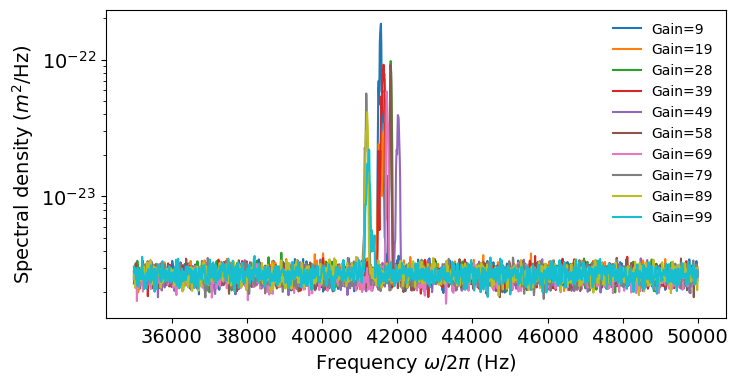

In [151]:
lb, ub = 3500, 5000
fig, ax = plt.subplots(figsize=(8,4))

variance = []
omega0, gamma_eff = [], []
for i, p in enumerate(pp):
    # Fit with a Lorentzian and plot
    lb_fit, ub_fit = 4000, 4300
    popt, omega_fit, p_fit = fit_peak(ff[i][lb_fit:ub_fit]*2*np.pi, p[lb_fit:ub_fit], peak_func, p0=[535, 42000*2*np.pi, 500])

    omega0.append(popt[1])
    gamma_eff.append(popt[2])
    variance.append(np.trapz(p[lb:ub]/c_cal_square, ff[i][lb:ub]))
    
    ax.plot(ff[i][lb:ub], p[lb:ub]/c_cal_square, label=f'Gain={gain[i]}')

    
ax.set_yscale('log')
ax.legend(frameon=False)
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($m^2$/Hz)', fontsize=14)

In [63]:
hbar = 6.63e-34

# Particle mass
rho = 2000 # kg/m^3
r   = 167e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3 

C:\Users\microspheres\AppData\Local\Temp\ipykernel_19992\387833535.py:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.asarray(x)) + c


Text(0, 0.5, 'Phonon occupancy $\\overline{n}$')

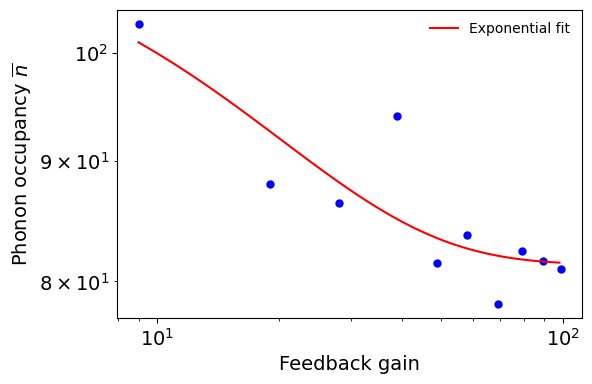

In [72]:
fig, ax = plt.subplots(figsize=(6,4))

nphonon = m * np.asarray(omega0) * np.asarray(omega0) * variance / (hbar * np.asarray(omega0))
ax.plot(gain, nphonon, 'b.', markersize=10)

def func(x, a, b, c):
    return a * np.exp(-b * np.asarray(x)) + c
popt, pcov = curve_fit(func, gain, nphonon)
ax.plot(np.arange(gain[0], gain[-1]), func(np.arange(gain[0], gain[-1]), *popt), 'r-', label='Exponential fit')

ax.legend(frameon=False)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Feedback gain', fontsize=14)
ax.set_ylabel('Phonon occupancy $\overline{n}$', fontsize=14)

## See if there are kicks when no pulses are applied to the sphere

Text(0.5, 0, 'Time (s)')

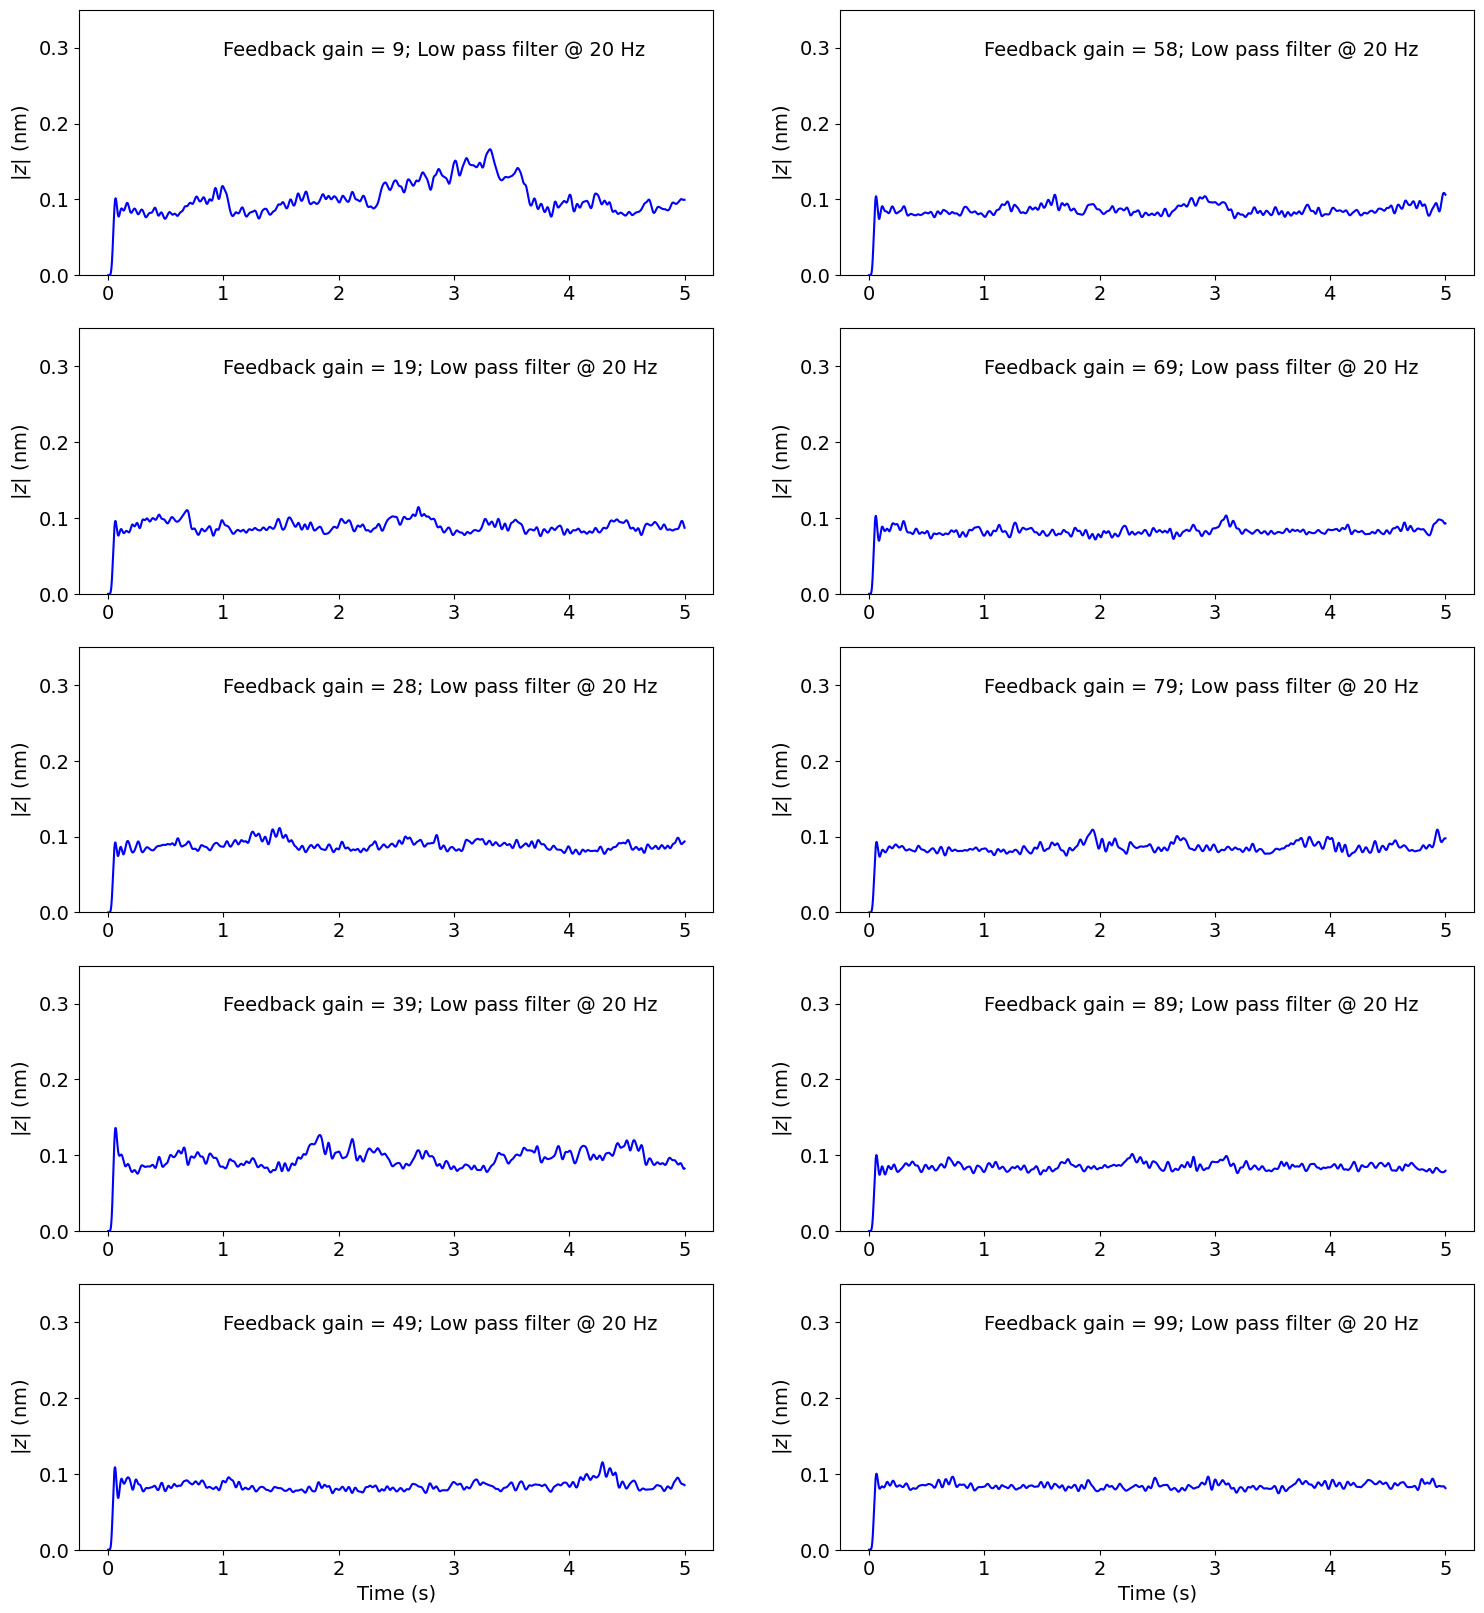

In [137]:
fig, ax = plt.subplots(5, 2, figsize = (18, 20))

for i, g in enumerate(gain):
    d = data[i]
    
    filtered = get_filtered_signal(d, 40000, 43000)
    z_nm = filtered/np.sqrt(c_cal_square)/1e-9
    fs = int(np.ceil(1 / (d[0, 1] - d[0, 0])))

    lp_filtered = lowpass_filtered(np.sqrt(z_nm**2), fs, 20)

    if i < 5:
        ax[i][0].plot(d[0], lp_filtered, label="Z detection (filtered)", color='blue')
        ax[i][0].text(1, 0.29, f'Feedback gain = {g}; Low pass filter @ 20 Hz', fontsize=14)
    else:
        ax[i-5][1].plot(d[0], lp_filtered, label="Z detection (filtered)", color='blue')
        ax[i-5][1].text(1, 0.29, f'Feedback gain = {g}; Low pass filter @ 20 Hz', fontsize=14)
        
for a in ax.flatten():
    a.set_ylim(0, 0.35)
    a.set_ylabel('$|z|$ (nm)', fontsize=14)
    
ax[4][0].set_xlabel('Time (s)', fontsize=14)
ax[4][1].set_xlabel('Time (s)', fontsize=14)

The case that there are real kicks. Can't remember what exactly was the feedback gain, perhaps 49.

In [113]:
file_kick_1 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_01.csv"
file_kick_2 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_02.csv"
file_kick_3 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_03.csv"
file_kick_4 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_04.csv"
file_kick_5 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_05.csv"
file_kick_6 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_06.csv"
file_kick_7 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_07.csv"
file_kick_8 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_08.csv"
file_kick_9 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_09.csv"
file_kick_10 = r"D:\Experiment\Pulse\20231118\pulse_20v_6us\pulse_20v_2us_10.csv"

data_kick_1 = np.genfromtxt(file_kick_1, delimiter=',', skip_header=3).T
data_kick_2 = np.genfromtxt(file_kick_2, delimiter=',', skip_header=3).T
data_kick_3 = np.genfromtxt(file_kick_3, delimiter=',', skip_header=3).T
data_kick_4 = np.genfromtxt(file_kick_4, delimiter=',', skip_header=3).T
data_kick_5 = np.genfromtxt(file_kick_5, delimiter=',', skip_header=3).T
data_kick_6 = np.genfromtxt(file_kick_6, delimiter=',', skip_header=3).T
data_kick_7 = np.genfromtxt(file_kick_7, delimiter=',', skip_header=3).T
data_kick_8 = np.genfromtxt(file_kick_8, delimiter=',', skip_header=3).T
data_kick_9 = np.genfromtxt(file_kick_9, delimiter=',', skip_header=3).T
data_kick_10 = np.genfromtxt(file_kick_10, delimiter=',', skip_header=3).T

In [115]:
data_kick = [data_kick_1, data_kick_2, data_kick_3, data_kick_4, data_kick_5, data_kick_6, data_kick_7, data_kick_8, data_kick_9, data_kick_10]

Text(0.5, 0, 'Time (s)')

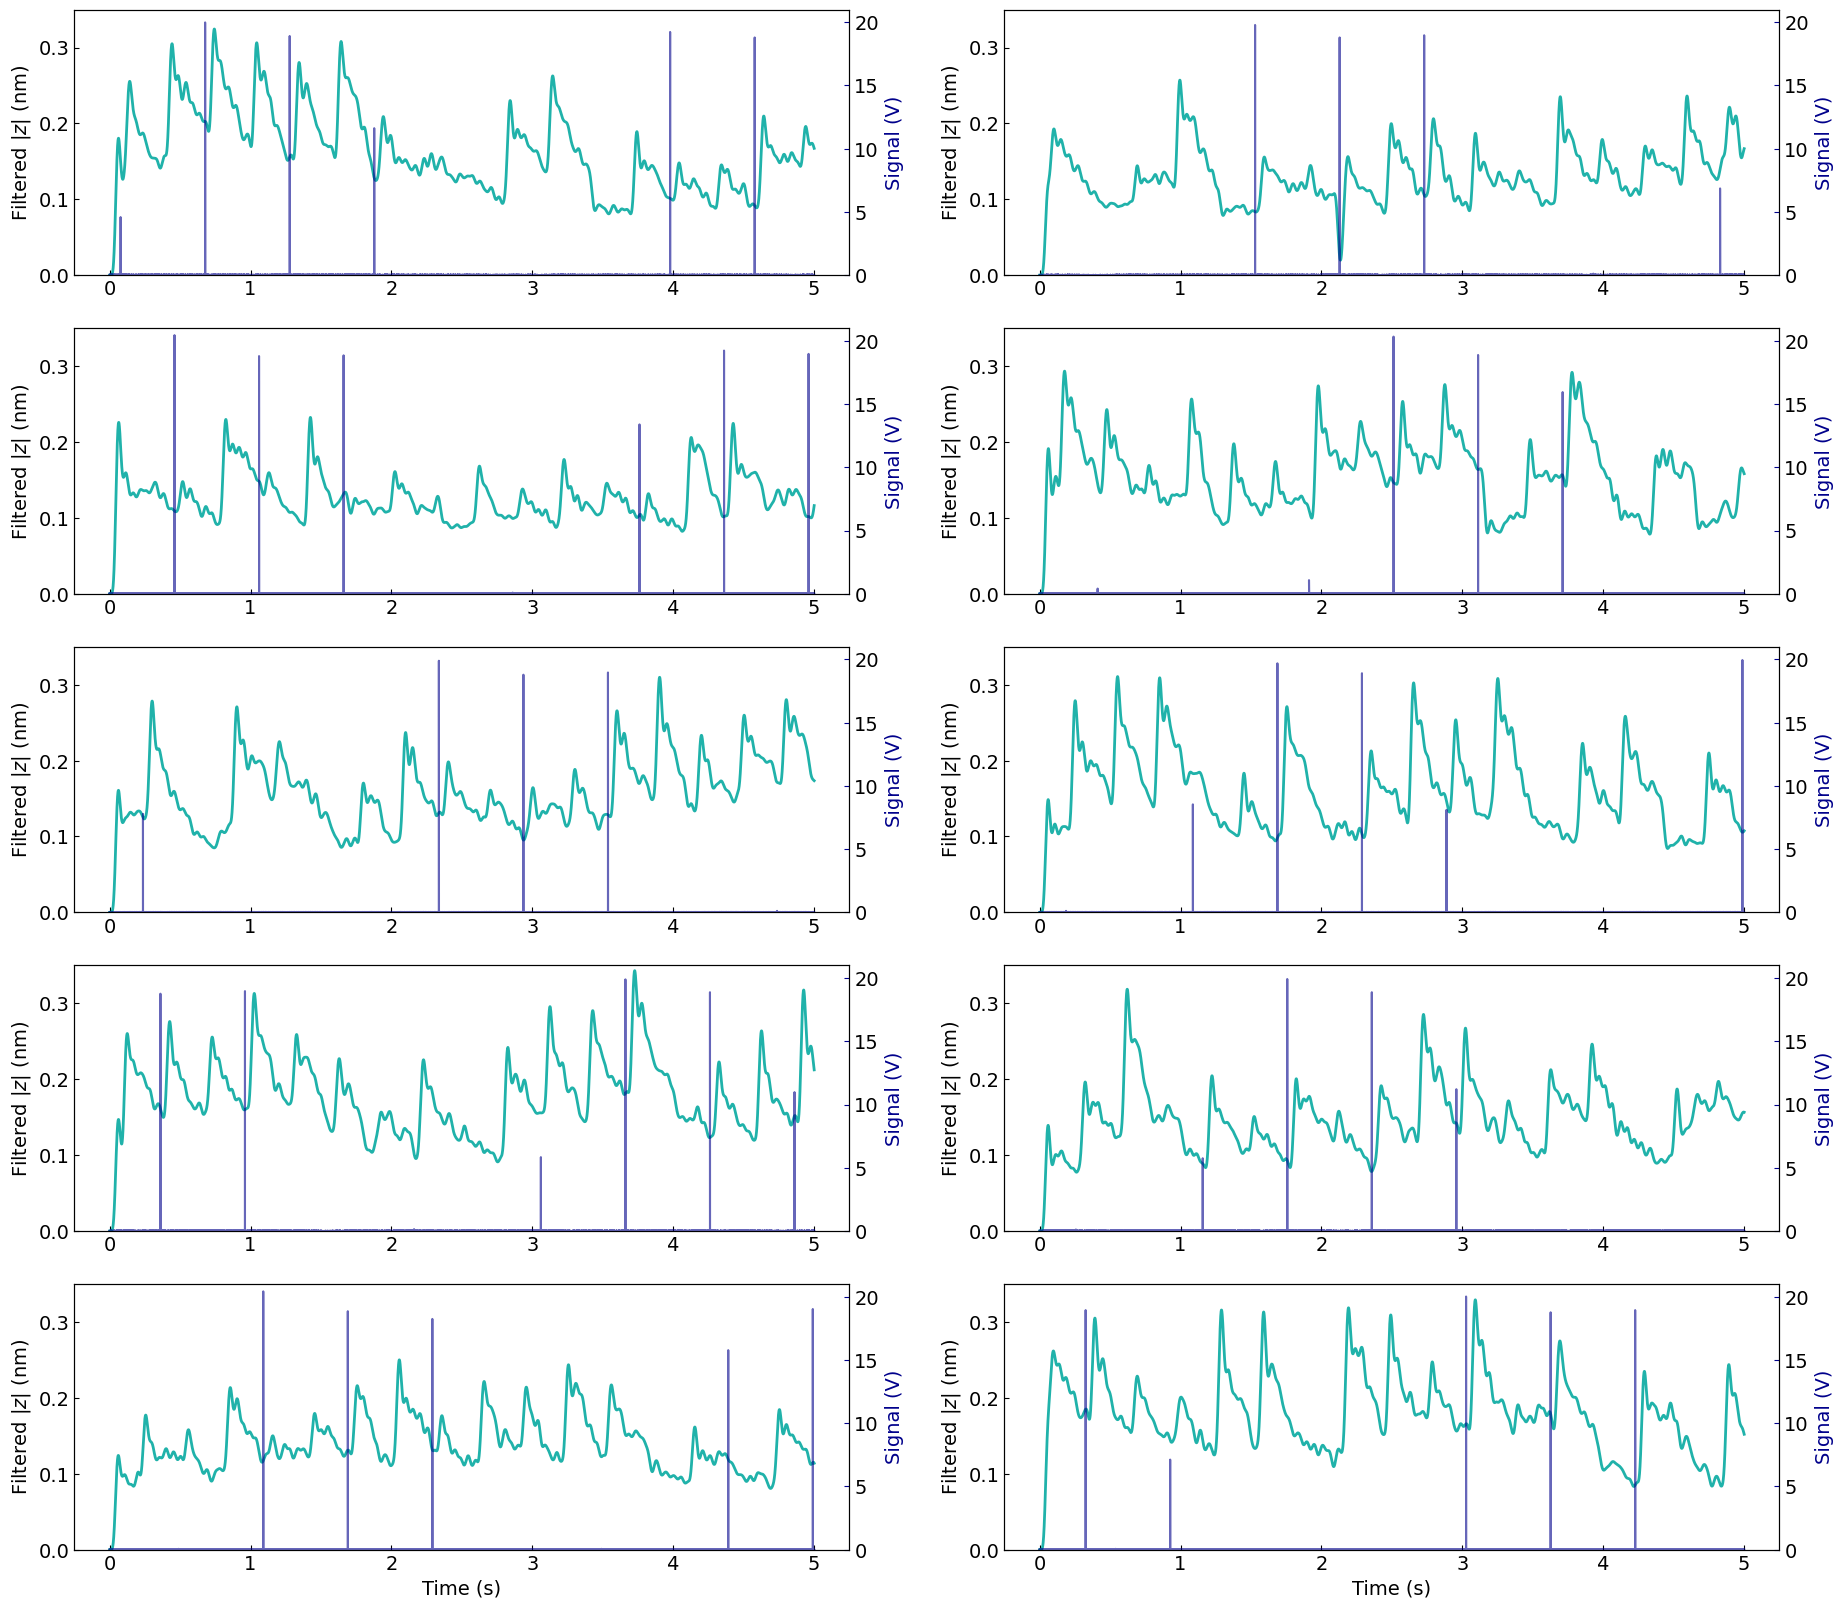

In [148]:
fig, ax = plt.subplots(5, 2, figsize = (22, 20))

for i, d in enumerate(data_kick):    
    filtered = get_filtered_signal(d, 40000, 43000)
    z_nm = filtered/np.sqrt(c_cal_square)/1e-9
    fs = int(np.ceil(1 / (d[0, 1] - d[0, 0])))

    lp_filtered = lowpass_filtered(np.sqrt(z_nm**2), fs, 20)

    if i < 5:
        ax[i][0].plot(d[0], lp_filtered, label="Z detection (filtered)", color='lightseagreen', linewidth=2)
        ax2 = ax[i][0].twinx()

    else:
        ax[i-5][1].plot(d[0], lp_filtered, label="Z detection (filtered)", color='lightseagreen', linewidth=2)
        ax2 = ax[i-5][1].twinx()
        
    ax2.plot(d[0], d[2], 'darkblue', alpha=0.6)
    ax2.set_ylabel('Signal (V)', fontsize=14, color='darkblue')
    ax2.tick_params(axis='both', which='both', direction='in', labelsize=14, color='darkblue')
    ax2.set_ylim(0, 21)

for a in ax.flatten():
    a.set_ylim(0, 0.35)
    a.set_ylabel('Filtered $|z|$ (nm)', fontsize=14)
    a.tick_params(axis='both', which='both', direction='in', labelsize=14)
    
ax[4][0].set_xlabel('Time (s)', fontsize=14)
ax[4][1].set_xlabel('Time (s)', fontsize=14)

In [138]:
file_kick_10_1 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_01.csv"
file_kick_10_2 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_02.csv"
file_kick_10_3 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_03.csv"
file_kick_10_4 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_04.csv"
file_kick_10_5 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_05.csv"
file_kick_10_6 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_06.csv"
file_kick_10_7 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_07.csv"
file_kick_10_8 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_08.csv"
file_kick_10_9 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_09.csv"
file_kick_10_10 = r"D:\Experiment\Pulse\20231118\pulse_10v_6us\pulse_10v_2us_10.csv"

data_kick_10_1 = np.genfromtxt(file_kick_10_1, delimiter=',', skip_header=3).T
data_kick_10_2 = np.genfromtxt(file_kick_10_2, delimiter=',', skip_header=3).T
data_kick_10_3 = np.genfromtxt(file_kick_10_3, delimiter=',', skip_header=3).T
data_kick_10_4 = np.genfromtxt(file_kick_10_4, delimiter=',', skip_header=3).T
data_kick_10_5 = np.genfromtxt(file_kick_10_5, delimiter=',', skip_header=3).T
data_kick_10_6 = np.genfromtxt(file_kick_10_6, delimiter=',', skip_header=3).T
data_kick_10_7 = np.genfromtxt(file_kick_10_7, delimiter=',', skip_header=3).T
data_kick_10_8 = np.genfromtxt(file_kick_10_8, delimiter=',', skip_header=3).T
data_kick_10_9 = np.genfromtxt(file_kick_10_9, delimiter=',', skip_header=3).T
data_kick_10_10 = np.genfromtxt(file_kick_10_10, delimiter=',', skip_header=3).T

data_kick_10 = [data_kick_10_1, data_kick_10_2, data_kick_10_3, data_kick_10_4, data_kick_10_5, data_kick_10_6, data_kick_10_7, data_kick_10_8, data_kick_10_9, data_kick_10_10]

Text(0.5, 0, 'Time (s)')

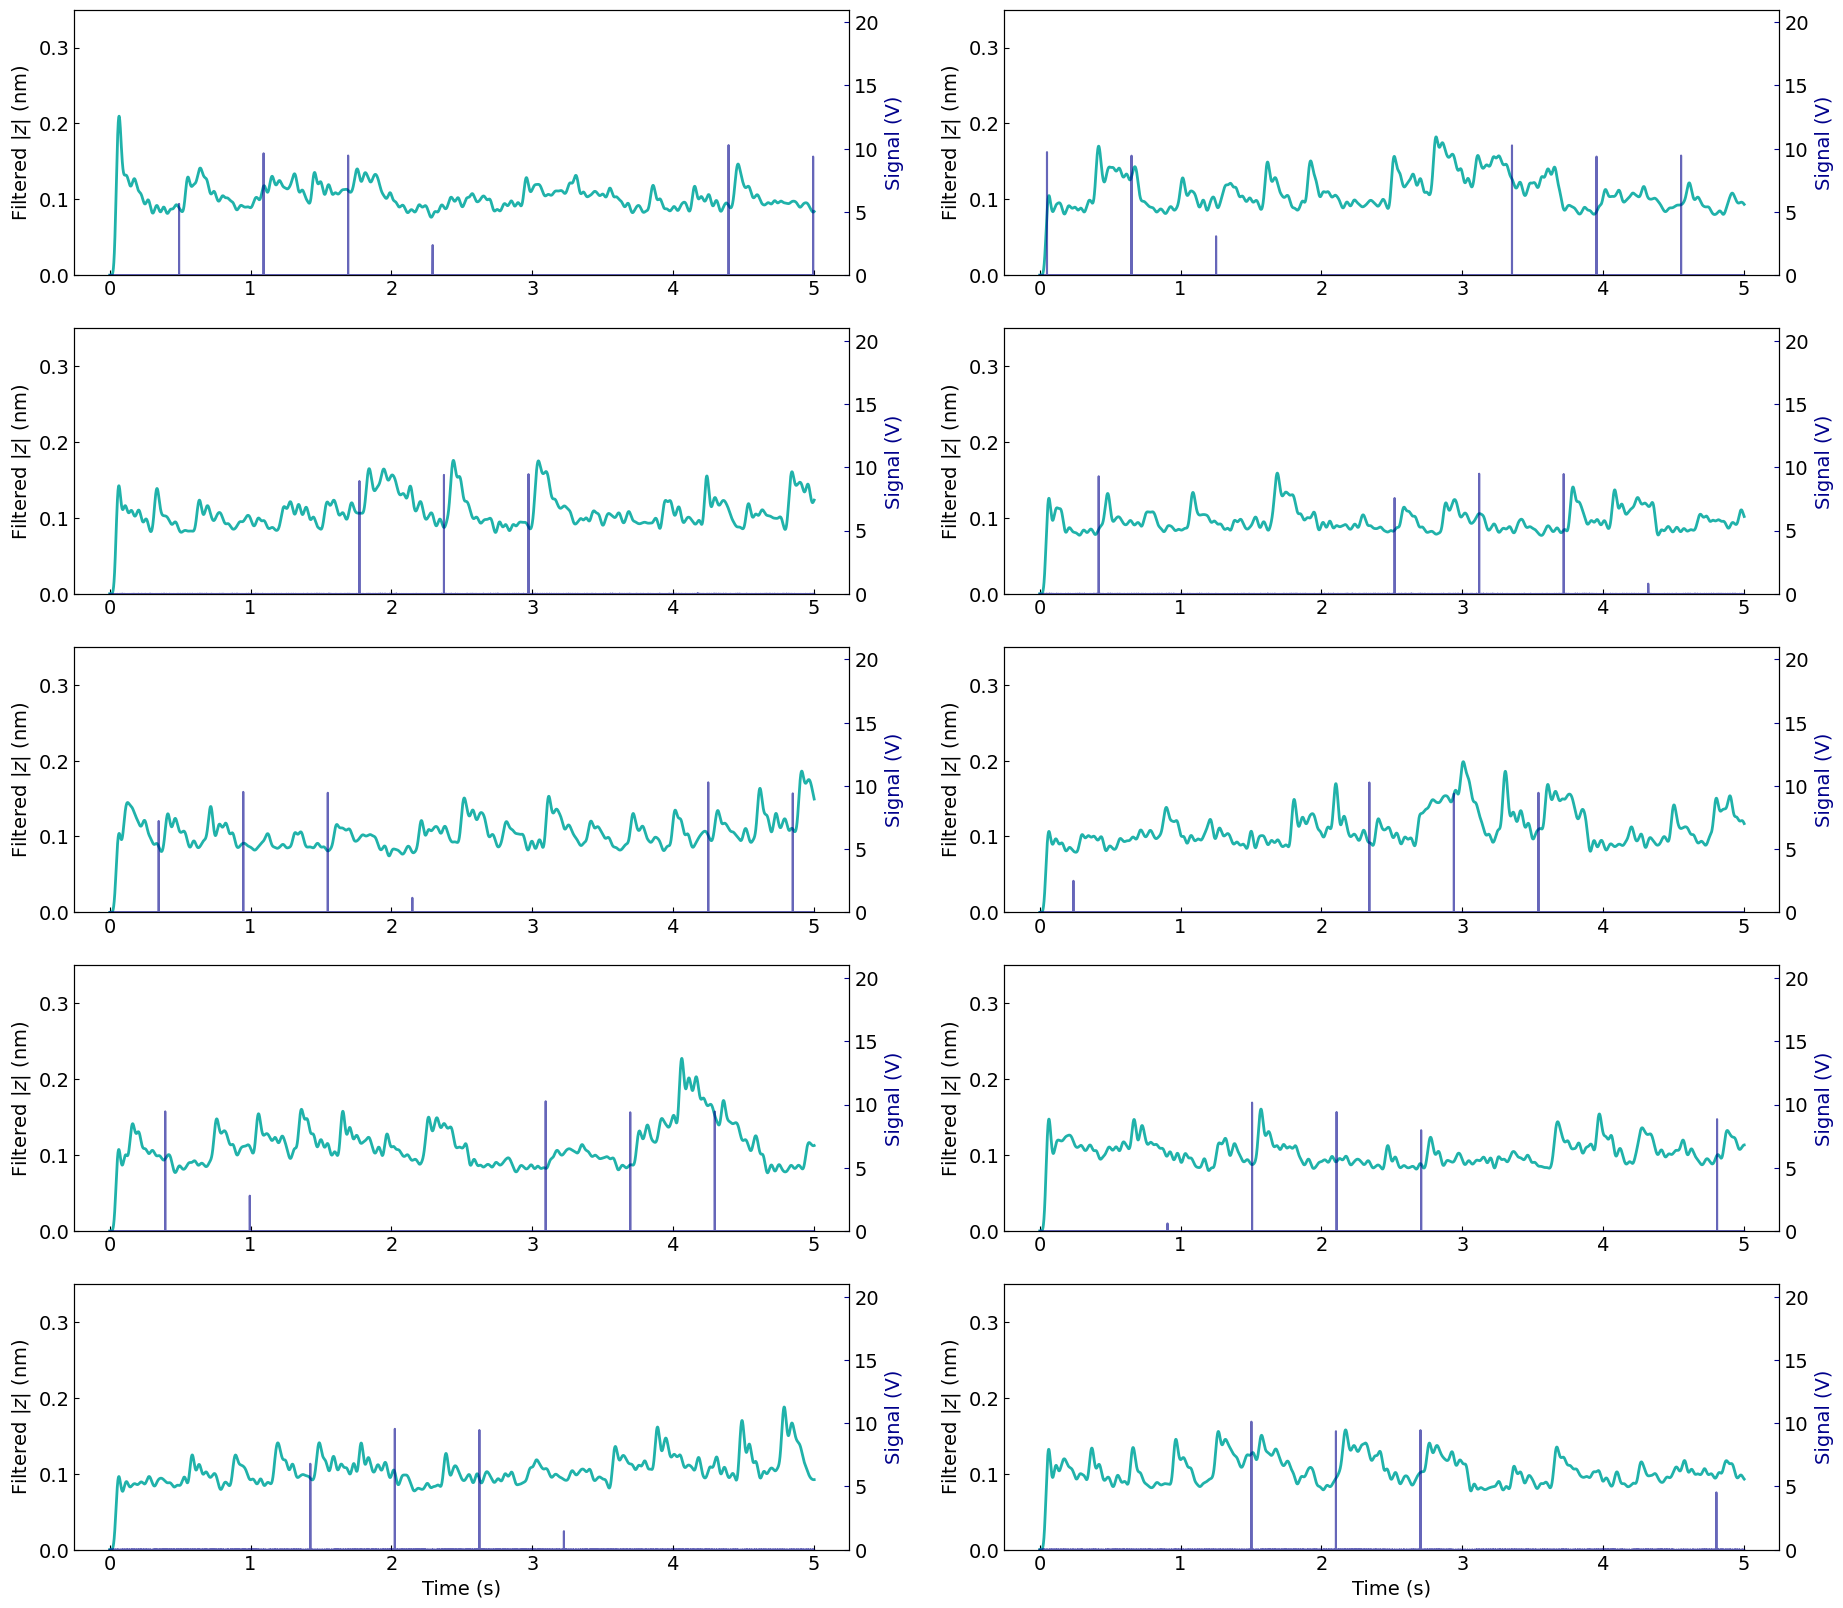

In [149]:
fig, ax = plt.subplots(5, 2, figsize = (22, 20))

for i, d in enumerate(data_kick_10):    
    filtered = get_filtered_signal(d, 40000, 43000)
    z_nm = filtered/np.sqrt(c_cal_square)/1e-9
    fs = int(np.ceil(1 / (d[0, 1] - d[0, 0])))

    lp_filtered = lowpass_filtered(np.sqrt(z_nm**2), fs, 20)

    if i < 5:
        ax[i][0].plot(d[0], lp_filtered, label="Z detection (filtered)", color='lightseagreen', linewidth=2)
        ax2 = ax[i][0].twinx()

    else:
        ax[i-5][1].plot(d[0], lp_filtered, label="Z detection (filtered)", color='lightseagreen', linewidth=2)
        ax2 = ax[i-5][1].twinx()
        
    ax2.plot(d[0], d[2], 'darkblue', alpha=0.6)
    ax2.set_ylabel('Signal (V)', fontsize=14, color='darkblue')
    ax2.tick_params(axis='both', which='both', direction='in', labelsize=14, color='darkblue')
    ax2.set_ylim(0, 21)
        
for a in ax.flatten():
    a.set_ylim(0, 0.35)
    a.set_ylabel('Filtered $|z|$ (nm)', fontsize=14)
    a.tick_params(axis='both', which='both', direction='in', labelsize=14)
    
ax[4][0].set_xlabel('Time (s)', fontsize=14)
ax[4][1].set_xlabel('Time (s)', fontsize=14)

In [152]:
file_kick_5_1 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_01.csv"
file_kick_5_2 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_02.csv"
file_kick_5_3 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_03.csv"
file_kick_5_4 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_04.csv"
file_kick_5_5 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_05.csv"
file_kick_5_6 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_06.csv"
file_kick_5_7 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_07.csv"
file_kick_5_8 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_08.csv"
file_kick_5_9 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_09.csv"
file_kick_5_10 = r"D:\Experiment\Pulse\20231118\pulse_5v_6us_2\pulse_5v_6us_2_10.csv"

data_kick_5_1 = np.genfromtxt(file_kick_5_1, delimiter=',', skip_header=3).T
data_kick_5_2 = np.genfromtxt(file_kick_5_2, delimiter=',', skip_header=3).T
data_kick_5_3 = np.genfromtxt(file_kick_5_3, delimiter=',', skip_header=3).T
data_kick_5_4 = np.genfromtxt(file_kick_5_4, delimiter=',', skip_header=3).T
data_kick_5_5 = np.genfromtxt(file_kick_5_5, delimiter=',', skip_header=3).T
data_kick_5_6 = np.genfromtxt(file_kick_5_6, delimiter=',', skip_header=3).T
data_kick_5_7 = np.genfromtxt(file_kick_5_7, delimiter=',', skip_header=3).T
data_kick_5_8 = np.genfromtxt(file_kick_5_8, delimiter=',', skip_header=3).T
data_kick_5_9 = np.genfromtxt(file_kick_5_9, delimiter=',', skip_header=3).T
data_kick_5_10 = np.genfromtxt(file_kick_5_10, delimiter=',', skip_header=3).T

data_kick_5 = [data_kick_5_1, data_kick_5_2, data_kick_5_3, data_kick_5_4, data_kick_5_5, data_kick_5_6, data_kick_5_7, data_kick_5_8, data_kick_5_9, data_kick_5_10]

Text(0.5, 0, 'Time (s)')

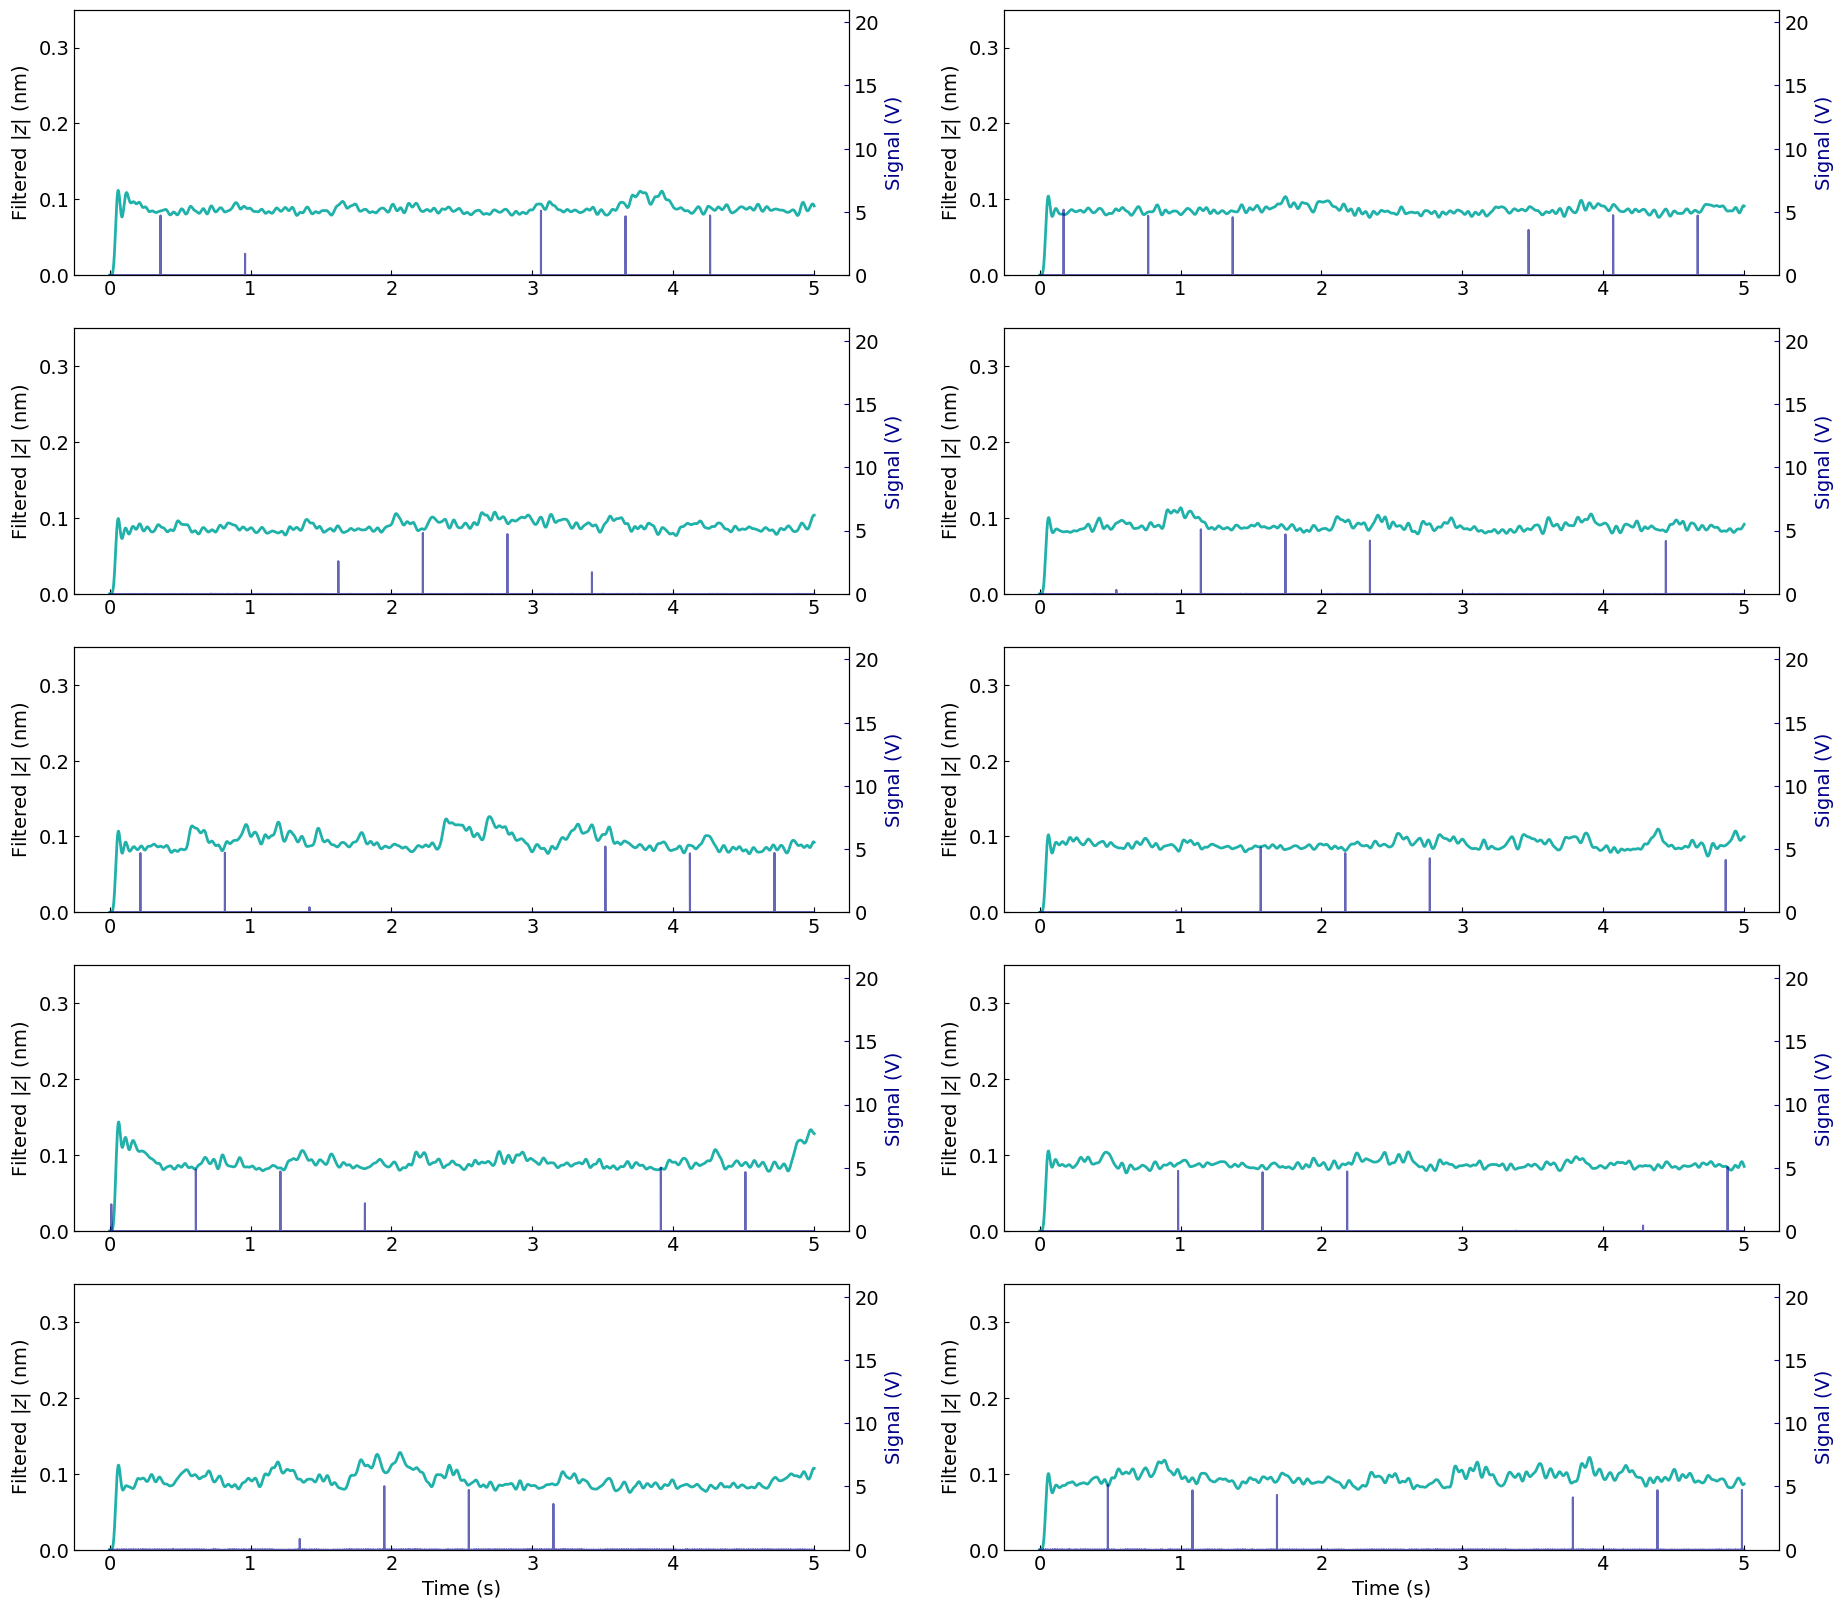

In [153]:
fig, ax = plt.subplots(5, 2, figsize = (22, 20))

for i, d in enumerate(data_kick_5):    
    filtered = get_filtered_signal(d, 40000, 43000)
    z_nm = filtered/np.sqrt(c_cal_square)/1e-9
    fs = int(np.ceil(1 / (d[0, 1] - d[0, 0])))

    lp_filtered = lowpass_filtered(np.sqrt(z_nm**2), fs, 20)

    if i < 5:
        ax[i][0].plot(d[0], lp_filtered, label="Z detection (filtered)", color='lightseagreen', linewidth=2)
        ax2 = ax[i][0].twinx()

    else:
        ax[i-5][1].plot(d[0], lp_filtered, label="Z detection (filtered)", color='lightseagreen', linewidth=2)
        ax2 = ax[i-5][1].twinx()
        
    ax2.plot(d[0], d[2], 'darkblue', alpha=0.6)
    ax2.set_ylabel('Signal (V)', fontsize=14, color='darkblue')
    ax2.tick_params(axis='both', which='both', direction='in', labelsize=14, color='darkblue')
    ax2.set_ylim(0, 21)
        
for a in ax.flatten():
    a.set_ylim(0, 0.35)
    a.set_ylabel('Filtered $|z|$ (nm)', fontsize=14)
    a.tick_params(axis='both', which='both', direction='in', labelsize=14)
    
ax[4][0].set_xlabel('Time (s)', fontsize=14)
ax[4][1].set_xlabel('Time (s)', fontsize=14)

In [142]:
file_kick_05_1 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_01.csv"
file_kick_05_2 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_02.csv"
file_kick_05_3 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_03.csv"
file_kick_05_4 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_04.csv"
file_kick_05_5 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_05.csv"
file_kick_05_6 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_06.csv"
file_kick_05_7 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_07.csv"
file_kick_05_8 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_08.csv"
file_kick_05_9 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_09.csv"
file_kick_05_10 = r"D:\Experiment\Pulse\20231118\pulse_05v_6us\pulse_05v_6us_10.csv"

data_kick_05_1 = np.genfromtxt(file_kick_05_1, delimiter=',', skip_header=3).T
data_kick_05_2 = np.genfromtxt(file_kick_05_2, delimiter=',', skip_header=3).T
data_kick_05_3 = np.genfromtxt(file_kick_05_3, delimiter=',', skip_header=3).T
data_kick_05_4 = np.genfromtxt(file_kick_05_4, delimiter=',', skip_header=3).T
data_kick_05_5 = np.genfromtxt(file_kick_05_5, delimiter=',', skip_header=3).T
data_kick_05_6 = np.genfromtxt(file_kick_05_6, delimiter=',', skip_header=3).T
data_kick_05_7 = np.genfromtxt(file_kick_05_7, delimiter=',', skip_header=3).T
data_kick_05_8 = np.genfromtxt(file_kick_05_8, delimiter=',', skip_header=3).T
data_kick_05_9 = np.genfromtxt(file_kick_05_9, delimiter=',', skip_header=3).T
data_kick_05_10 = np.genfromtxt(file_kick_05_10, delimiter=',', skip_header=3).T

data_kick_05 = [data_kick_05_1, data_kick_05_2, data_kick_05_3, data_kick_05_4, data_kick_05_5, data_kick_05_6, data_kick_05_7, data_kick_05_8, data_kick_05_9, data_kick_05_10]

Text(0.5, 0, 'Time (s)')

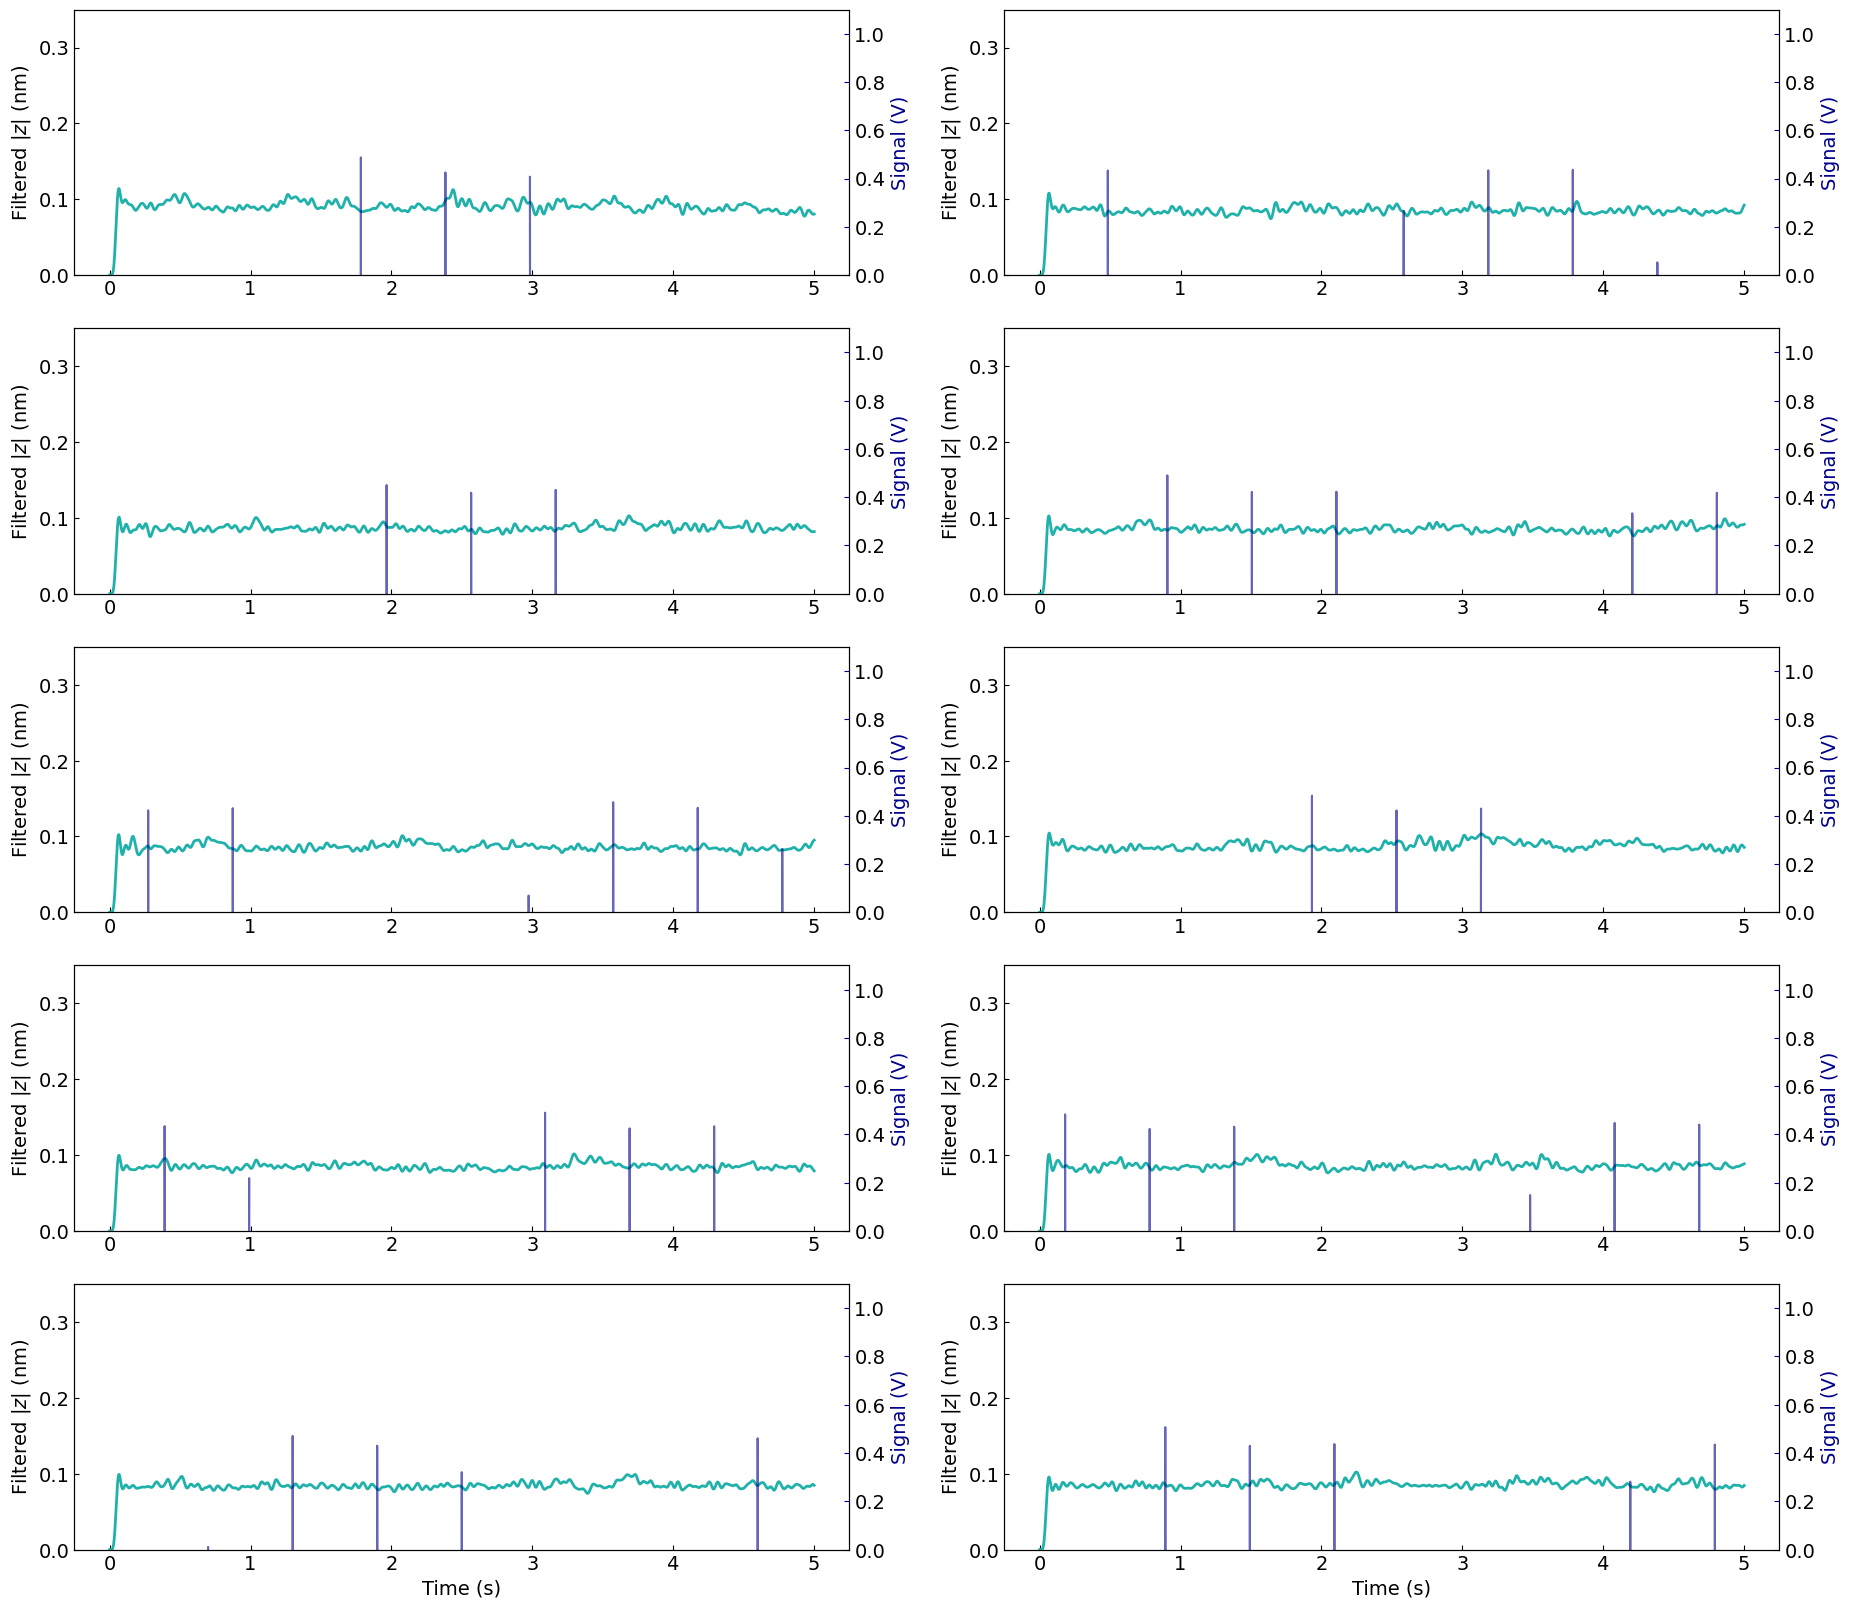

In [150]:
fig, ax = plt.subplots(5, 2, figsize = (22, 20))

for i, d in enumerate(data_kick_05):    
    filtered = get_filtered_signal(d, 40000, 43000)
    z_nm = filtered/np.sqrt(c_cal_square)/1e-9
    fs = int(np.ceil(1 / (d[0, 1] - d[0, 0])))

    lp_filtered = lowpass_filtered(np.sqrt(z_nm**2), fs, 20)

    if i < 5:
        ax[i][0].plot(d[0], lp_filtered, label="Z detection (filtered)", color='lightseagreen', linewidth=2)
        ax2 = ax[i][0].twinx()

    else:
        ax[i-5][1].plot(d[0], lp_filtered, label="Z detection (filtered)", color='lightseagreen', linewidth=2)
        ax2 = ax[i-5][1].twinx()
        
    ax2.plot(d[0], d[2], 'darkblue', alpha=0.6)
    ax2.set_ylabel('Signal (V)', fontsize=14, color='darkblue')
    ax2.tick_params(axis='both', which='both', direction='in', labelsize=14, color='darkblue')
    ax2.set_ylim(0, 1.1)
        
for a in ax.flatten():
    a.set_ylim(0, 0.35)
    a.set_ylabel('Filtered $|z|$ (nm)', fontsize=14)
    a.tick_params(axis='both', which='both', direction='in', labelsize=14)
    
ax[4][0].set_xlabel('Time (s)', fontsize=14)
ax[4][1].set_xlabel('Time (s)', fontsize=14)